### 中心节点操作流程
- 轨迹生成
- 聚类操作（kmedoids），但此时的聚类结果是无序的
- 原始数据网格化
- 聚类得到簇心结果，然后将所有网格化数据对这些簇心进行比较，从而得到有序的聚类结果

In [34]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import DBSCAN 
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from hausdorff import hausdorff_distance

from Bio.Cluster import kmedoids
import pickle

In [4]:
NODE_NUM = 3

#### 轨迹生成

In [7]:
def loadPara():
    allPara = []
    with open('node1para.pickle', 'rb') as f:
        para = pickle.load(f)
    allPara.append(para)
    with open('node2para.pickle', 'rb') as f:
        para = pickle.load(f)
    allPara.append(para)
    with open('node3para.pickle', 'rb') as f:
        para = pickle.load(f)
    allPara.append(para)
    return allPara

In [12]:
def trGendrator(allPara):
    returnTr = []
    for n in range(NODE_NUM):
        nodePara = allPara[n]
        for j in range(len(nodePara)):
            cPara = nodePara[j]
            firstPoints = cPara['firstP']
            maxLength = cPara['maxL']
            transMatrix = cPara['transM']
            allState = cPara['allS']
            for i in range(len(firstPoints)):
                genTr = []
                nowP = firstPoints[i]
                genTr.append(nowP)
                for m in range(maxLength):
                    pro = list(transMatrix.loc[nowP])
                    if np.isnan(pro[0]):
                        break
                    n = np.random.choice(len(allState),1,p = pro)
                    genTr.append(allState[n[0]])
                    nowP = allState[n[0]]
                returnTr.append(genTr)
    return returnTr

<function matplotlib.pyplot.show(*args, **kw)>

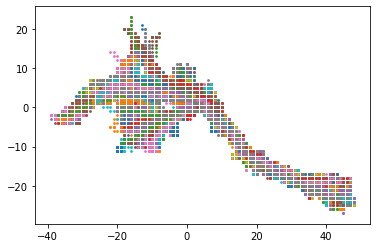

In [18]:
for i in range(len(GEN_TR)):
    x = [p[0] for p in GEN_TR[i]]
    y = [p[1] for p in GEN_TR[i]]
    plt.scatter(x,y,3)
plt.show

#### 聚类操作

In [26]:
def dist(a,b):
    
    return hausdorff_distance(a,b)

In [27]:
def distMatrix(data):
    length = len(data)
    mat = [[]]
    for i in range(1,length):
        tmp = []
        for j in range(i):
            tmp.append(dist(np.array(data[i]),np.array(data[j])))
        mat.append(tmp) 
    return mat

In [36]:
#  clusterid 中的类号是指的是代表聚类中心的元素号。
def cluster(data,K,mat):
    clusterid, error, nfound = kmedoids(mat,K,npass = 10)
    return clusterid

In [70]:
def cost(data,labels):
    loss = 0
    for i in range(len(data)):
        loss = loss + dist(np.array(data[i]),np.array(data[labels[i]]))
    loss = loss / len(data)
    return loss

In [71]:
def chooseK(data,K,mat):
    x = np.arange(3,K+1)
    y = np.zeros(len(x))
    for k in range(3,K+1):
        labels = cluster(data,k,mat)
        y[k-3] = cost(data, labels)
    plt.plot(x,y)
    plt.show()

#### 原始数据网格化

In [11]:
def df2array(df):
    # 将数据以 ndarray 的形式读入内存
    # [[x1,x2,...,x500,y1,y2,...,y500],[],...]
    i = 0
    data = np.array([])
    while i <= len(df)-1:
        arr_x = np.array(df['x'][i:i+POINTS_NUM_PER_TR])
        arr_y = np.array(df['y'][i:i+POINTS_NUM_PER_TR])
        arr = np.append(arr_x,arr_y)
        if len(data)==0:
            data = np.array([arr])
        else:
            data = np.append(data,[arr],axis=0)
        i+=POINTS_NUM_PER_TR
    return data

In [8]:
def discretization(data):
    
    # 网格坐标化
    data = np.round(data)
    tr_point = [    [  (data[j][i],data[j][i+POINTS_NUM_PER_TR])    for i in range(POINTS_NUM_PER_TR)]     
                           for j in range(len(data))]
    
    
    # 去掉连续落在同一区间上的点
    for i in range(len(tr_point)):
        tmp = []
        l = tr_point[i].copy()
        for j in range(POINTS_NUM_PER_TR-1):
            if l[j] == l[j+1]:
                tmp.append(j)
        tr_point[i] = [l[i] for i in range(POINTS_NUM_PER_TR) if i not in tmp]
        
    # 防止出现跨越的点
    for i in range(len(tr_point)):
        tmp = tr_point[i].copy()  # [(),(),...,()]
        count = 0 # 添加的点造成的偏移
        for j in range(len(tmp) - 1):
            now_p = tmp[j]
            next_p = tmp[j + 1]
            if not(tr_point[i][j + count] == now_p and tr_point[i][j + count + 1] == next_p):
                print('WRONGGGGG: ',now_p,next_p,tr_point[i][j + count],tr_point[i][j + count],)
                break
            if now_p[0] == next_p[0] and abs(now_p[1] - next_p[1]) == 1:
                continue
            elif abs(now_p[0] - next_p[0]) == 1 and now_p[1] == next_p[1]:
                continue   
            else:
                # print(now_p,next_p)
                delta_x = int(abs(now_p[0] - next_p[0]))
                delta_y = int(abs(now_p[1] - next_p[1]))
                if delta_x == 0:
                    step = (next_p[1] - now_p[1]) / delta_y
                    for k in range(1,delta_y,1):
                        tr_point[i].insert(j + count + k,(now_p[0],now_p[1] + k * step))
                    count = count + delta_y - 1
                    continue
                elif delta_y == 0:
                    step = (next_p[0] - now_p[0])/delta_x
                    for k in range(1,delta_x,1):
                        tr_point[i].insert(j + count + k,(now_p[0] + k * step,now_p[1]))
                    count = count + delta_x - 1
                    continue
                else:
                    step_x = (next_p[0] - now_p[0])/delta_x
                    step_y = (next_p[1] - now_p[1]) / delta_y
                    k = 1
                    while delta_x != 0 and delta_y != 0:
                        tr_point[i].insert(j + count + 1,(now_p[0] + k * step_x,now_p[1]))
                        tr_point[i].insert(j + count + 2,(now_p[0] + k * step_x,now_p[1] + k * step_y))
                        count = count + 2
                        k = k + 1
                        delta_x = delta_x - 1
                        delta_y = delta_y - 1
                    if delta_x == 0 and delta_y == 0:
                        tr_point[i].pop(j + count)
                        count = count - 1
                    elif delta_x == 0:
                        step = (next_p[1] - now_p[1]) / delta_y
                        for k in range(1,delta_y,1):
                            tr_point[i].insert(j + count + k,(now_p[0],now_p[1] + k * step))
                        count = count + delta_y - 1
                        continue
                    elif delta_y == 0:
                        step = (next_p[0] - now_p[0])/delta_x
                        for k in range(1,delta_x,1):
                            tr_point[i].insert(j + count + k,(now_p[0] + k * step,now_p[1]))
                        count = count + delta_x - 1
                        continue
                        
    return tr_point

#### ================加载参数，生成轨迹================

In [8]:
PARA = loadPara()

In [66]:
GEN_TR = trGendrator(PARA)

In [68]:
len(GEN_TR)

968

#### ================生成数据集上的聚类，得到簇心================

In [69]:
MAT = distMatrix(GEN_TR)

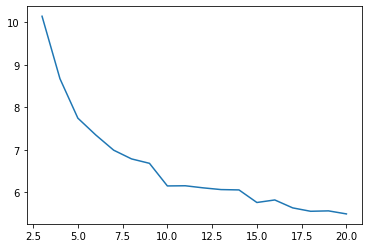

In [74]:
chooseK(GEN_TR,20,MAT)

In [63]:
ours = list(set(cluster(GEN_TR,7,MAT)))
ours

[774, 328, 746, 110, 693, 217, 127]

#### ================原始数据网格化================

In [9]:
POINTS_NUM_PER_TR = 500

df = pd.read_csv('../data/all.csv')

NUM_TR = int(len(df)/POINTS_NUM_PER_TR)

In [12]:
DATA = df2array(df)

In [13]:
DISC_DATA = discretization(DATA)

#### ================对比试验================

In [64]:
l2 = []
for i in GEN_TR:
    distArr = []
    for j in range(7):
        distArr.append(hausdorff_distance(np.array(i),np.array(GEN_TR[ours[j]])))
    minDist = np.min(distArr)
    l2.append(distArr.index(minDist))

In [65]:
np.array(l2)

array([3, 3, 3, 3, 4, 3, 3, 1, 4, 4, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3, 0, 5,
       4, 3, 4, 3, 0, 3, 3, 3, 3, 4, 0, 4, 0, 4, 0, 0, 3, 3, 3, 4, 3, 3,
       3, 0, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 0, 3, 0, 3, 3, 3, 3, 4, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 6, 6, 6, 6, 4, 6, 5,
       3, 3, 6, 6, 6, 6, 5, 6, 6, 3, 6, 5, 6, 5, 5, 6, 6, 6, 5, 6, 3, 6,
       6, 6, 6, 6, 5, 6, 3, 6, 4, 3, 0, 6, 3, 6, 3, 6, 6, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 5, 2, 4,
       3, 5, 6, 5, 6, 5, 3, 5, 5, 6, 4, 0, 5, 6, 6, 5, 4, 6, 6, 5, 5, 6,
       6, 6, 5, 5, 6, 6, 2, 3, 5, 5, 5, 2, 5, 5, 6, 6, 5, 5, 3, 5, 5, 5,
       5, 5, 2, 2, 6, 2, 2, 6, 2, 2, 1, 2, 5, 2, 6, 2, 2, 2, 5, 2, 2, 2,
       2, 2, 2, 2, 5, 5, 5, 5, 2, 1, 6, 5, 2, 5, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 6, 0, 0, 3, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 3,
       3, 3, 0, 0, 0, 4, 4, 3, 0, 0, 0, 0, 0, 0, 0,